
# Importing Required Libraries

This section imports the necessary libraries for data manipulation, audio processing, visualization, and machine learning.

In [2]:
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Loading Training Metadata

This section reads the training metadata from a CSV file and displays the first few rows along with some basic statistics about the dataset

In [3]:
df_train = pd.read_csv('metadata of train set .csv')
print(df_train.columns)
df_train.head(10)

Index(['Filename', 'File ID', 'Duration in ms', 'Class ID', 'Classname',
       'augmentation  id', 'Augmentation  type', 'source'],
      dtype='object')


,Filename,File ID,Duration in ms,Class ID,Classname,augmentation id,Augmentation type,source
0,108160-1_0_0.wav,108160,3730,0,breath,0,Orignal,https://freesound.org/
1,108160-2_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/
2,108160-3_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/
3,108160-4_0_0.wav,108160,2226,0,breath,0,Orignal,https://freesound.org/
4,146769-1_0_0.wav,146769,3540,0,breath,0,Orignal,https://freesound.org/
5,151215_0_0.wav,151215,3690,0,breath,0,Orignal,https://freesound.org/
6,162254-1_0_0.wav,162254,4000,0,breath,0,Orignal,https://freesound.org/
7,162254-2_0_0.wav,162254,4000,0,breath,0,Orignal,https://freesound.org/
8,164101-32_0_0.wav,164101,3860,0,breath,0,Orignal,https://freesound.org/
9,169222-1_0_0.wav,169222,3690,0,breath,0,Orignal,https://freesound.org/


# Extracting Features from Audio Samples
This section iterates through the audio samples, extracts features using the defined function, and stores them in a DataFrame.

In [4]:
import librosa
import numpy as np
import tqdm
from sklearn.preprocessing import StandardScaler

import librosa
import numpy as np

def extract_features(y, sr, 
                    #  n_mfcc=13,
                     n_mels=128):
    # **MFCC Features**
    # mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # (n_mfcc, time_frames)
    # delta_mfcc = librosa.feature.delta(mfcc)  # (n_mfcc, time_frames)
    zcr = librosa.feature.zero_crossing_rate(y)  # (1, time_frames)
    # rms = librosa.feature.rms(y=y)  # (1, time_frames)
    # spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # (1, time_frames)
    # spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)  # (1, time_frames)
    # spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)  # (1, time_frames)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)  # (n_mels, time_frames)
    mel_spec_db = librosa.power_to_db(mel_spec)  # Convert to dB scale
    features = np.vstack((
        # delta_mfcc,  # MFCC & Delta
        zcr, 
        # rms, spectral_centroid, spectral_bandwidth, spectral_rolloff,  # Spectral Features
        mel_spec_db  # Log-Mel Spectrogram
    ))  # Final shape: (feature_dim, time_frames)
    return features  # Shape: (feature_dim, time_frames)


def normalize_audio(y):
    """Normalize the waveform to the range [-1, 1]."""
    return y / np.max(np.abs(y)) if np.max(np.abs(y)) > 0 else y


In [4]:
features = []
labels = []

for i, row in tqdm.tqdm(df_train.iterrows(), desc='Processing Audio', total=len(df_train)):
    path = 'train/' + row['Filename']
    
    # Load the audio file
    y, sr = librosa.load(path,sr=8000)  # Keep original sample rate
    # Preprocessing: Normalize and smooth
    y = librosa.util.fix_length(y, size=8000*4)  # Ensure 4s length
    # y = normalize_audio(y)
    extracted_features = extract_features(y,sr)
    features.append(extracted_features)
    labels.append(row['Class ID'])

Processing Audio: 100%|██████████| 6289/6289 [01:04<00:00, 98.20it/s] 


In [5]:
# # Convert to numpy array and scale
features = np.array(features)
features.shape

(6289, 129, 63)

# Defining the CNN Model
This section defines a convolutional neural network (CNN) model architecture for audio classification.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class CNNModel(nn.Module):
    def __init__(self, input_size=(129, 63), num_classes=7):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.1)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(0.1)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.dropout3 = nn.Dropout(0.2)

        self.conv6 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(256)

        self.dropout4 = nn.Dropout(0.2)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Reshape (batch_size, 174, 251) → (batch_size, 1, 174, 251)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool1(x)
        x = self.dropout3(x)

        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))

        x = torch.mean(x, dim=[2, 3])  # Global Average Pooling across height & width
        x = self.dropout4(x)
        x = self.fc(x)
        return x


# Model initialization
model = CNNModel()
summary(model, input_size=(64,129, 63))  # Batch size 64


c:\Users\91820\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [64, 7]                   --
├─Conv2d: 1-1                            [64, 64, 129, 63]         640
├─BatchNorm2d: 1-2                       [64, 64, 129, 63]         128
├─Dropout: 1-3                           [64, 64, 129, 63]         --
├─Conv2d: 1-4                            [64, 128, 129, 63]        73,856
├─BatchNorm2d: 1-5                       [64, 128, 129, 63]        256
├─Conv2d: 1-6                            [64, 128, 129, 63]        147,584
├─BatchNorm2d: 1-7                       [64, 128, 129, 63]        256
├─Dropout: 1-8                           [64, 128, 129, 63]        --
├─Conv2d: 1-9                            [64, 128, 129, 63]        147,584
├─BatchNorm2d: 1-10                      [64, 128, 129, 63]        256
├─Conv2d: 1-11                           [64, 128, 129, 63]        147,584
├─BatchNorm2d: 1-12                      [64, 128, 129, 63]  

# Handling Class Imbalance with SMOTE
This section applies SMOTE to the training data to handle class imbalance before training the model.  
The model was predincting only the top three classes(frequency wise) and hence performed really well on accuracy but had really poor precision and f1 score so this was an attempt to fix that


In [7]:
features.shape

(6289, 129, 63)

In [8]:
import torch
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F


# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X = np.array(features, dtype=np.float32)
y = np.array(labels, dtype=np.int64) 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

from torch.utils.data import DataLoader, WeightedRandomSampler
import torch
# Compute class weights (inverse frequency)
class_counts = np.bincount(y_train)  # Count occurrences per class
class_weights = 1.0 / class_counts
weights = class_weights[y_train]  # Assign weights to each sample
# Create sampler
sampler = WeightedRandomSampler(weights, len(weights))

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long, device=device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long, device=device)

batch_size = 64  

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size,sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Using device: cuda


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)  # Ensure model is on GPU
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [7]:
import torch
# torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  16137 KiB |    772 MiB |   5956 MiB |   5941 MiB |
|       from large pool |  14080 KiB |    770 MiB |   5953 MiB |   5940 MiB |
|       from small pool |   2057 KiB |      3 MiB |      3 MiB |      1 MiB |
|---------------------------------------------------------------------------|
| Active memory         |  16137 KiB |    772 MiB |   5956 MiB |   5941 MiB |
|       from large pool |  14080 KiB |    770 MiB |   5953 MiB |

In [11]:
df_train['Class ID'].value_counts()

Class ID
2    1791
0    1690
3    1133
1     632
4     593
5     236
6     214
Name: count, dtype: int64

# Training the Model
This section trains the model on the resampled training data and validates it using early stopping.

In [12]:
epochs = 50
patience = 16  # Number of epochs to wait before stopping if no improvement
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_path = "best_model.pth"  # Path to save the best model

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    correct, total = 0, 0
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    val_acc = correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0  # Reset counter if improvement
        torch.save(model.state_dict(), best_model_path)  # Save best model
        # print(f"Best model saved at epoch {epoch+1}.")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break  # Stop training

# Load best model after training
model.load_state_dict(torch.load(best_model_path))
print("Best model loaded for evaluation.")


Epoch 1, Loss: 114.2876, Val Loss: 9.7145, Val Acc: 0.6328
Epoch 2, Loss: 85.7388, Val Loss: 7.8666, Val Acc: 0.7202
Epoch 3, Loss: 68.3789, Val Loss: 6.1688, Val Acc: 0.8108
Epoch 4, Loss: 62.5782, Val Loss: 10.2903, Val Acc: 0.6518
Epoch 5, Loss: 53.9904, Val Loss: 7.2943, Val Acc: 0.7488
Epoch 6, Loss: 50.1907, Val Loss: 7.3479, Val Acc: 0.7599
Epoch 7, Loss: 44.2317, Val Loss: 17.1524, Val Acc: 0.5310
Epoch 8, Loss: 43.7879, Val Loss: 5.2989, Val Acc: 0.8394
Epoch 9, Loss: 41.2577, Val Loss: 6.9817, Val Acc: 0.7838
Epoch 10, Loss: 36.4425, Val Loss: 9.3082, Val Acc: 0.6948
Epoch 11, Loss: 34.9630, Val Loss: 4.4534, Val Acc: 0.8506
Epoch 12, Loss: 35.1251, Val Loss: 6.9824, Val Acc: 0.7695
Epoch 13, Loss: 32.7794, Val Loss: 4.3332, Val Acc: 0.8553
Epoch 14, Loss: 30.9341, Val Loss: 5.6364, Val Acc: 0.8235
Epoch 15, Loss: 28.5508, Val Loss: 6.2006, Val Acc: 0.8140
Epoch 16, Loss: 29.9603, Val Loss: 7.4028, Val Acc: 0.7615
Epoch 17, Loss: 25.3990, Val Loss: 4.9686, Val Acc: 0.8506
Epo

# Loading and Standardizing Test Features
This section loads the test audio files, extracts features, and standardizes them for evaluation.

In [8]:
df_test =pd.read_csv('metadata of test set.csv')
df_test.drop([ 'Augment Id','Augmentation type'], axis=1, inplace=True)
df_test.head(5)

,Filename,File_ID,Durationin ms,Class_id,Classname,source
0,112557-2_0_0.wav,112557,4000,0,breath,https://freesound.org/
1,112557-3_0_0.wav,112557,3950,0,breath,https://freesound.org/
2,112557-4_0_0.wav,112557,3910,0,breath,https://freesound.org/
3,140301_0_0.wav,140301,2261,0,breath,https://freesound.org/
4,144128-1_0_0.wav,144128,3770,0,breath,https://freesound.org/


In [9]:
features_test = []
labels_test = []

for i, row in tqdm.tqdm(df_test.iterrows(), desc='Loading : ', total=len(df_test)):
    path = 'test/' + row['Filename']
    y,sr=librosa.load(path,sr=8000)
    y = librosa.util.fix_length(y, size=8000*4)  # Ensure 4s length
    y = normalize_audio(y)
    extracted_features_test = extract_features(y,sr)
    features_test.append(extracted_features_test)
    labels_test.append(row['Class_id'])
 

Loading : 100%|██████████| 725/725 [00:11<00:00, 64.68it/s] 


In [10]:
# Convert to NumPy array
features_test = np.array(features_test)

print("Final Feature Shape:", features_test.shape)


Final Feature Shape: (725, 129, 63)


In [11]:
X_test =features_test
y_test =labels_test
X_test = np.array(X_test) 
y_test = np.array(y_test) 


# Evaluating Model Performance
This section evaluates the model's performance on the test data using precision, recall, F1 score, and confusion matrix.

In [12]:
# Load best model after training
best_model_path = "best_model.pth"  # Path to save the best model

model.load_state_dict(torch.load(best_model_path))
print("Best model loaded for evaluation.")

Best model loaded for evaluation.


In [16]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)  # Assuming labels are integers

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

model.eval()
# Disable gradient computation for testing
with torch.no_grad():
    outputs = model(X_test_tensor)  # Forward pass
    test_loss = criterion(outputs, y_test_tensor)  # Compute loss
    preds = torch.argmax(outputs, dim=1)  # Get predicted class
    correct = (preds == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)

    test_acc = correct / total  # Compute accuracy

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 1.0699, Test Accuracy: 0.6841


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

model.eval()

# Disable gradient computation for testing
with torch.no_grad():
    outputs = model(X_test_tensor)  # Forward pass
    test_loss = criterion(outputs, y_test_tensor)  # Compute loss
    y_pred_classes = torch.argmax(outputs, dim=1)  # Get predicted class
    correct = (preds == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    test_acc = correct / total  # Compute accuracy


# Move tensors to CPU and convert to NumPy arrays
y_test_np = y_test_tensor.cpu().numpy()
y_pred_np = y_pred_classes.cpu().numpy()

# Compute precision, recall, and F1-score
precision = precision_score(y_test_np, y_pred_np, average='weighted')
recall = recall_score(y_test_np, y_pred_np, average='weighted')
f1 = f1_score(y_test_np, y_pred_np, average='weighted')

# Print classification report
print(classification_report(y_test_np, y_pred_np))
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

              precision    recall  f1-score   support

           0       0.94      0.55      0.69       160
           1       0.54      0.89      0.67        70
           2       0.92      0.47      0.62       205
           3       0.71      0.87      0.78       140
           4       0.55      0.89      0.68        70
           5       0.49      0.80      0.61        30
           6       0.53      0.82      0.65        50

    accuracy                           0.68       725
   macro avg       0.67      0.76      0.67       725
weighted avg       0.76      0.68      0.68       725

Test Loss: 1.0699, Test Accuracy: 0.6841
Precision: 0.7648
Recall: 0.6841
F1 Score: 0.6805


: 

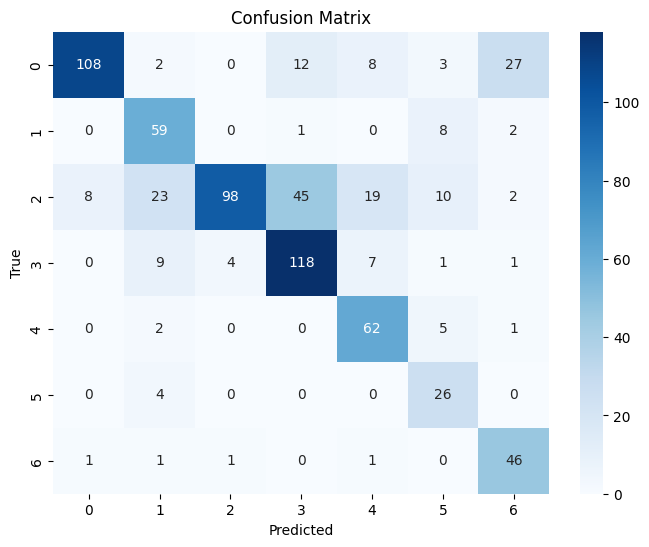

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch

# Ensure predictions and true labels are on CPU and converted to numpy
y_pred_classes = y_pred_classes.cpu().numpy() if isinstance(y_pred_classes, torch.Tensor) else y_pred_classes
# y_true = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [25]:
#with delta_mfcc n=13
Precision: 0.8116
Recall: 0.7531
F1 Score: 0.7703

#no -mfcc




SyntaxError: invalid syntax (3830206545.py, line 4)